In [2]:
import argparse
import os
import struct
import sys

1. Напишите скрипт, читающий во всех mp3-файлах указанной директории ID3v1-теги и выводящий информацию о каждом файле в виде: `[имя исполнителя] - [название трека] - [название альбома]`. Если пользователь при вызове скрипта задает ключ -d, то выведите для каждого файла также 16-ричный дамп тега. Скрипт должен также автоматически проставить номера треков и жанр (номер жанра задается в параметре командной строки), если они не проставлены. Используйте модуль struct.  
ID3v1-заголовки располагаются в последних 128 байтах mp3-файла.  
Структура заголовка отражена в таблице

| Поле | Длина(байт) | Описание |
| -- | -- | -- |
| header | 3 | 3 символа: "TAG" |
| title | 30 | 30 символов названия трека |
| artist | 30 | 30 символов имени исполнителя |
| album | 30 | 30 символов названия альбома |
| year | 4 | 4 символа года издания |
| comment | 28 или 30 | Комментарий |
| zero-byte | 1 | Если в теге хранится номер трека, то этот байт зарезервирован под 0 |
| track | 1 | Номер трека альбома или 0. Имеет смысл, если предыдущий байт равен 0 |
| genre | 1 | Индекс в списке жанров или 255 |

In [4]:
import subprocess

cmds = [sys.executable,'mp3reader.py','-s','music','-d']
output = subprocess.check_output(cmds)
print(output.decode('windows-1251'))


title['Ain't No Reason'], artist['Brett Dennen'], album['Ain't No Reason'], year[2007], dump[b'54414741696e2774204e6f20526561736f6e00000000000000000000000000000042726574742044656e6e656e00000000000000000000000000000000000041696e2774204e6f20526561736f6e00000000000000000000000000000032303037636f6d6d000000000000000000000000000000000000000000000000000811']
title['This I love'], artist['Guns N' Roses'], album['Chinese Democracy'], year[2008], dump[b'544147546869732049206c6f76650000000000000000000000000000000000000047756e73204e2720526f73657300000000000000000000000000000000004368696e6573652044656d6f63726163790000000000000000000000000032303038436f6c6c656374656400000000000000000000000000000000000000000d4f']
title['In the End'], artist['Linkin Park'], album['Hybrid Theory'], year[2000], dump[b'544147496e2074686520456e6400000000000000000000000000000000000000004c696e6b696e205061726b00000000000000000000000000000000000000487962726964205468656f7279000000000000000000000000000000000032303030636f6d6d0000

2. Напишите скрипт для информационной системы библиотеки. База данных библиотеки включает таблицы «Авторы» с полями «id», «имя», «страна», «годы жизни», и «Книги» с полями «id автора», «название», «количество страниц», «издательство», «год издания»). Необходимо производить авторизацию пользователей, логины и пароли которых хранятся в отдельной таблице. Пароли должны храниться в зашифрованном виде (например, хэш SHA-1 или MD5). В программе должны быть окна для отображения информации о всех книгах и авторах, окно добавления книги/автора. Реализуйте также возможность сохранения информации о выделенном авторе в файле в формате `json` или `XML` (по выбору пользователя). При добавлении нового автора в базу допускается не заполнять поля в соответствующем окне, а распарсить файл, указанный пользователем (файл необходимо заранее создать и заполнить информацией вручную, в текстовом редакторе). Для преобразования в формат XML и json напишите собственный код; парсинг можно делать с помощью сторонних библиотек. Форматы файлов:

JSON
```json            
{
"name": "L.N.Tolstoi",
"country": "Russia",
"years": [1828, 1910]
}
``` 
XML
```XML
<author>
<name>L.N.Tolstoi</Name>
<country>Russia</Country>
<years born=”1828” died=”1910”/>
</author>
```

In [3]:
%gui qt
import sqlite3
import hashlib
import sys
import wx
import threading
import UiAddAuthor
import UiAddBook
import UiMainWin
import UiAuthorization
import UiShowAuthor
import UiShowBook
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtGui import *
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from FileManager import FileManager


class AuthorizationWindowStart(QtWidgets.QMainWindow):
    #логин: admin, пароль: 12345
    def __init__(self, parent=None):
        QtWidgets.QWidget.__init__(self, parent)
        self.ui = UiAuthorization.Ui_MainWindow()
        self.ui.setupUi(self)
        self.ui.pushButton.clicked.connect(self.log_in)

        
    def log_in(self):
        try:
            self.login = self.ui.line_login.text()
            self.password = self.ui.line_password.text()
        except Exception as e:
            print('Error with getting data from textLines: ', e.args)
        db = sqlite3.connect('Library.db')
        with db:
            cursor = db.cursor()
            hash_log = hashlib.md5(self.login.encode()).hexdigest()
            hash_pass = hashlib.md5(self.password.encode()).hexdigest()
            try:
                cursor.execute('SELECT * FROM Пользователи')
            except Exception as e:
                print('Error with taking info about users: ', e.args)
            users = cursor.fetchall()
            for user in users:
                log, passw = user
                if hash_log == log and hash_pass == passw:
                    self.show_main_window()
                else:
                    msg = QtWidgets.QMessageBox()
                    msg.setWindowTitle("Внимание!")
                    msg.setText("Неверные логин и/или пароль!")
                    msg.exec_()

                    
    @pyqtSlot()
    def show_main_window(self):
        self.main_window = MainWindow()
        self.main_window.show()
        self.close()


class MainWindow(QtWidgets.QMainWindow):
    def __init__(self, parent=None):
        # QtWidgets.QWidget.__init__(self, parent)
        super().__init__(parent)
        self.ui = UiMainWin.Ui_MainWindow()
        self.ui.setupUi(self)

        self.show_author_infoF = None
        self.show_book_infoF = None
        self.add_authorF = None
        self.add_bookF = None

        self.ui.button_addauthor.clicked.connect(self.add_author)
        self.ui.button_addbook.clicked.connect(self.add_book)
        self.ui.button_findauthor.clicked.connect(self.show_author_info)
        self.ui.button_findbook.clicked.connect(self.show_book_info)

    def show_author_info(self):
        try:
            author_id = self.ui.line_auth.text()
            db = sqlite3.connect('Library.db')
        except Exception as ex:
            print(ex.args)
        with db:
            cursor = db.cursor()
            request = u'SELECT * FROM Авторы WHERE id = ' + author_id
            try:
                cursor.execute(request)
            except Exception as e:
                print('Error with getting data from DB: ', e.args)
            try:
                found_authors = cursor.fetchall()
                if len(found_authors) == 0:
                    raise Exception('Автора с таким ID нет в базе данных.')
                try:
                    author = found_authors[0]
                    self.show_author_infoF = ShowAuthorInfoForm(data=author)
                    self.show_author_infoF.show()
                except Exception as e:
                    print('Error when opening author info form: ', e.args)
            except Exception as e:
                print(e)

                
    def show_book_info(self, dat):
        book_title = self.ui.line_book.text()
        db = sqlite3.connect('Library.db')
        with db:
            cursor = db.cursor()
            request = request = u'SELECT * FROM Книги WHERE Название = "' + book_title + u'"'
            cursor.execute(request)
            try:
                found_books = cursor.fetchall()
                if len(found_books) == 0:
                    raise Exception('Книги с таким названием нет.')
                book = found_books[0]
                self.show_book_infoF = ShowBookInfoForm(data=book)
                self.show_book_infoF.show()
            except Exception as e:
                print(e)
        

    @pyqtSlot()
    def add_author(self):
        self.add_authorF = ShowAddAuthorForm()
        self.add_authorF.show()

    @pyqtSlot()
    def add_book(self):
        self.add_bookF = ShowAddBookForm()
        self.add_bookF.show()


class ShowAuthorInfoForm(QtWidgets.QMainWindow):
    def __init__(self, data, parent=None):
        QtWidgets.QWidget.__init__(self, parent)
        self.ui = UiShowAuthor.Ui_MainWindow()
        self.ui.setupUi(self)

        self._info = data
        ID, name, country, years = data
        try:
            self.ui.label_auth_name.setText(str(name))
            self.ui.label_years_life.setText(str(years))
            self.ui.label_country.setText(str(country))
        except Exception as e:
            print('Some error when putting data on labels: ', e.args)
        self.ui.button_save_xml.clicked.connect(self.save_xml)
        self.ui.button_save_json.clicked.connect(self.save_json)
        self.ui.button_close.clicked.connect(self.closing)

        
    def save_xml(self):
        try:
            threading.Thread(target=FileManager.save_author_info_XML(self._info)).start()
            print('Saved into XML!')
        except Exception as e:
            print(e)

            
    def save_json(self):
        try:
            threading.Thread(target=FileManager.save_author_info_json(self._info)).start()
            print('Saved into Json!')
        except Exception as e:
            print(e)
            
            
    def closing(self):
        self.close()


class ShowBookInfoForm(QtWidgets.QMainWindow):
    def __init__(self, data, parent=None):
        QtWidgets.QWidget.__init__(self, parent)
        self.ui = UiShowBook.Ui_MainWindow()
        self.ui.setupUi(self)

        self._info = data
        authors_id, name, pages, publisher, year = data
        self.ui.label_auth_id.setText(str(authors_id))
        self.ui.label_name.setText(str(name))
        self.ui.label_pages.setText(str(pages))
        self.ui.label_publisher.setText(str(publisher))
        self.ui.label_years.setText(str(year))

        self.ui.button_save_xml.clicked.connect(self.save_book_xml)
        self.ui.button_save_json.clicked.connect(self.save_book_json)
        self.ui.button_close.clicked.connect(self.closing)

        
    def save_book_xml(self):
        try:
            threading.Thread(target=FileManager.save_book_info_xml(self._info)).start()
        except Exception as e:
            print(e.args)

            
    def save_book_json(self):
        try:
            threading.Thread(target=FileManager.save_book_info_json(self._info)).start()
        except Exception as e:
            print(e.args)

            
    def closing(self):
        self.close()

        
class ShowAddAuthorForm(QtWidgets.QMainWindow):
    def __init__(self, parent=None):
        QtWidgets.QWidget.__init__(self, parent)
        self.ui = UiAddAuthor.Ui_MainWindow()
        self.ui.setupUi(self)

        self.name = ''
        self.country = ''
        self.years = ''

        self.ui.button_add.clicked.connect(self.add_author)
        self.ui.button_close.clicked.connect(self.closing)

        
    def add_author(self):
        self.name = self.ui.line_author.text()
        self.country = self.ui.line_country.text()
        self.years = self.ui.line_years.text()
        db = sqlite3.connect('Library.db')
        try:
            with db:
                cursor = db.cursor()
                cursor.execute('INSERT INTO Авторы  VALUES(NULL, ?,?,?)', (self.name, self.country, self.years))
                db.commit()
                msg = QtWidgets.QMessageBox()
                msg.setWindowTitle("Успешно!")
                msg.setText("Данные об авторе успешно добавлены в базу.")
                msg.exec_()
        except Exception as e:
            print(e.args)
        
        
    def closing(self):
        self.close()

        
class ShowAddBookForm(QtWidgets.QMainWindow):
    def __init__(self, parent=None):
        QtWidgets.QWidget.__init__(self, parent)
        self.ui = UiAddBook.Ui_MainWindow()
        self.ui.setupUi(self)

        self.author_id = None
        self.title = ''
        self.sheets = None
        self.publisher = ''
        self.year = None

        self.ui.button_add_book.clicked.connect(self.add_book)
        self.ui.button_close.clicked.connect(self.closing)

        
    def add_book(self):
        self.author_id = int(self.ui.line_auth_id.text())
        self.title = self.ui.line_name.text()
        self.sheets = int(self.ui.line_pages.text())
        self.publisher = self.ui.line_publisher.text()
        self.year = int(self.ui.line_years.text())

        db = sqlite3.connect('Library.db')
        with db:
            cursor = db.cursor()
            try:
                cursor.execute('INSERT INTO Книги VALUES(?,?,?,?,?)', (self.author_id, self.title, self.sheets,
                                                                       self.publisher, self.year))
                db.commit()
            except Exception as e:
                print(e.args)
        QtWidgets.QMessageBox.question(self,
                                       'Done.',
                                       'Данные успешно загружены!',
                                       QtWidgets.QMessageBox.Ok, QtWidgets.QMessageBox.Ok)

        
    def closing(self):
        self.close()

if __name__ == '__main__':
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)
    w = AuthorizationWindowStart()
    w.show()
    app.exec_()

3. Выполните задание № 2 средствами SQLAlchemy, включая создание и редактирование таблиц, а также выполнение таких запросов, как:
    - вывод фамилий всех авторов, родившихся в диапазоне между X и Y годами (задайте программно числа X и Y);
    - вывод всех книг, написанных авторами из России;
    - вывод всех книг с количеством страниц более N;
    - вывод всех авторов с числом книг более N.

In [4]:
import sqlalchemy
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, ForeignKey

Base = declarative_base()


class Author(Base):
    __tablename__ = 'Авторы'

    id = Column(Integer, primary_key=True)
    name = Column(String, name='Имя')
    country = Column(String, name='Страна')
    years = Column(String, name='Годы_жизни')

    def __repr__(self):
        return "<Author(id={}, name='{}', country='{}', years='{}')>" \
            .format(self.id, self.name, self.country, self.years)


class Book(Base):
    __tablename__ = 'Книги'

    author_id = Column(Integer, ForeignKey('Авторы.id'), name='id_автора')
    name = Column(String, primary_key=True, name='Название')
    pages = Column(Integer, name='Количество_страниц')
    publisher = Column(String, name='Издательство')
    year = Column(Integer, name='Год_издания')

    def __repr__(self):
        return "<Author(author_id={}, title='{}', sheets_count={}," \
               " publisher='{}', year={})>" \
            .format(self.author_id, self.title, self.sheets_count,
                    self.publisher, self.year)


class User(Base):
    __tablename__ = 'Пользователи'
    login = Column(String, primary_key=True, name='Логин')
    password = Column(String, name='Пароль')

    def __repr__(self):
        return "<User(login='{}', password='{}'".format(self.login, self.password)


class AlchemyMethods:
    @staticmethod
    def task1(ses):
        print('1) вывод фамилий всех авторов, родившихся в диапазоне '
              'между X и Y годами (задайте программно числа X и Y)')
        X = int(input("Введите X: "))
        Y = int(input("Введите Y: "))
        for author in ses.query(Author):
            birth = int(author.years.split('-')[0])
            if X < birth < Y:
                print(author.name)
        print()

        
    @staticmethod
    def task2(ses):
        print('2) вывод всех книг, написанных авторами из России;')
        authors = ses.query(Author).filter(Author.country == 'Россия')
        for author in authors:
            books = ses.query(Book).filter(Book.author_id == author.id)
            for book in books:
                print(book.name)
        print()

        
    @staticmethod
    def task3(ses):
        print('3) вывод всех книг с количеством страниц более N;')
        N = int(input("Введите N: "))
        books = ses.query(Book).filter(Book.pages > N)
        for book in books:
            print(book.name)
        print()


    @staticmethod
    def task4(ses):
        print('4) вывод всех авторов с числом книг более N;')
        N = int(input("Введите N: "))
        for author in ses.query(Author):
            books = list(ses.query(Book).filter(Book.author_id == author.id))
            if len(books) > N:
                print(author.name)
        print()


    @staticmethod
    def processing():
        engine = sqlalchemy.create_engine('sqlite:///Library.db', echo=False)
        Session = sessionmaker(bind=engine)
        ses = Session()
        AlchemyMethods.task1(ses)
        AlchemyMethods.task2(ses)
        AlchemyMethods.task3(ses)
        AlchemyMethods.task4(ses)
        ses.close()


if __name__ == '__main__':
    AlchemyMethods.processing()

1) вывод фамилий всех авторов, родившихся в диапазоне между X и Y годами (задайте программно числа X и Y)
Введите X: 1899
Введите Y: 1921
Джордж Оруэлл
Рэй Брэдбери
Артур Кларк

2) вывод всех книг, написанных авторами из России;
Братья Карамазовы

3) вывод всех книг с количеством страниц более N;
Введите N: 400
Братья Карамазовы

4) вывод всех авторов с числом книг более N;
Введите N: 0
Джордж Оруэлл
Олдос Хаксли
Рэй Брэдбери
Артур Кларк
Фёдор Достоевский



4. Выполните задание № 3, используя в качестве базы данных NoSql-технологию MongoDB.

In [ ]:
import pymongo
#Задание опирается на методы SQLAlchemy для извлечения данных из .bd файла, поэтому
#перед запуском обязательно запустить предыдущую ячейку, чтобы были активны её классы и импорты.

client = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = client["mydatabase"]
col_authors = mydb['Authors']
col_books = mydb['Books']

#class AuthorMongo(Document):
#    id = IntField(required=True)
#    name = StringField(required=True, max_length=30)
#    country = StringField(required=True, max_length=30)
#    years = StringField(required=True, max_length=10)


#class BookMongo(Document):
#    author_id = IntField(required=True)
#    name = StringField(required=True, max_length=30)
#    pages = IntField(required=True)
#    publisher = StringField(required=True, max_length=30)
#    year = IntField(required=True)


#class UserMongo(Document):
#    login = StringField(required=True, max_length=30)
#    password = StringField(required=True, max_length=30)
    

class MongoMethods:
    @staticmethod
    def task1():
        print('1) вывод фамилий всех авторов, родившихся в диапазоне '
              'между X и Y годами (задайте программно числа X и Y)')
        X = int(input("Введите X: "))
        Y = int(input("Введите Y: "))
        search = col_authors.find({ "year_of_birth": { "$gt": X, "$lt" : Y } }, { "id": 0, "name": 1, "country": 0, "years": 0})
        for x in search:
            print(x)
    
    
    @staticmethod
    def task2():
        print('2) вывод всех книг, написанных авторами из России;')
        search = col_books.find({ "country": "Russia" })
        for x in search:
            print(x)
    
    
    @staticmethod
    def task3():
        print('3) вывод всех книг с количеством страниц более N;')
        N = int(input("Введите N: "))
        search = col_books.find({ "pages": { "$gt": N} })
        for x in search:
            print(x)
    
    
    @staticmethod
    def task4():
        print('4) вывод всех авторов с числом книг более N;')
        N = int(input("Введите N: "))
        search = col_authors.find({ "numbers_of_books": { "$gt": N} })
        for x in search:
            print(x)
    
    
    @staticmethod
    def from_db_to_mongo():
        engine = sqlalchemy.create_engine('sqlite:///Library.db', echo=False)
        Session = sessionmaker(bind=engine)
        ses = Session()
        for author in ses.query(Author):
            print("is it")
            books = list(ses.query(Book).filter(Book.author_id == author.id))
            n = len(books)
            curr_item = {"id" : author.id, 
                        "name" : author.name,
                        "country" : author.country,
                        "year_of_birth" : int(author.years.split('-')[0]),
                        "year_of_death" : int(author.years.split('-')[1]),
                        "number_of_books" : int(n)}
            print("it iss")
            x = col_authors.insert_one(curr_item)
        for book in ses.query(Book):
            authors = ses.query(Author).filter(Author.id == book.author_id)
            countr = authors[0].country
            curr_item = {"author_id" : book.author_id, 
                        "name" : book.name,
                        "pages" : int(book.pages),
                        "publisher" : book.publisher,
                        "year" : book.year,
                        "country" : countr}
            x = col_books.insert_one(curr_item)
        
        
    @staticmethod
    def starting():
        MongoMethods.from_db_to_mongo()
        MongoMethods.task1()
        MongoMethods.task2()
        MongoMethods.task3()
        MongoMethods.task4()
        
        
if __name__ == '__main__':
    MongoMethods.starting()

5. Напишите приложение для загрузки файлов из интернета. В главном окне должно быть три текстовых поля, в которые можно вводить URL файла на закачку; под каждым из текстовых полей должны быть индикаторы загрузки и рядом поля с процентом загрузки каждого файла. Необходимо организовать возможность качать от одного до трех файлов параллельно (**использовать потоки обязательно**, файлы загружать фрагментами по 4 Кб). Загрузка должна инициироваться нажатием кнопки *«Start downloading!»*. По окончанию загрузки последнего файла должно появиться окно со столбчатой диаграммой со значениями времени загрузки каждого файла в формате *«2s 322ms»* и размерами файлов (используйте библиотеку `matplotlib`).
![интерфейс](pic_1.png)

<IPython.core.display.Javascript object>


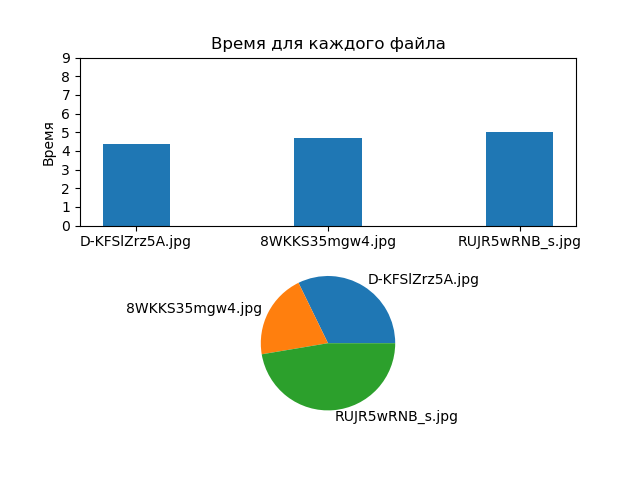

In [ ]:
%gui qt
%matplotlib notebook
import os
import threading
import Task5Window
import requests
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from time import time
from PyQt5 import QtCore, QtWidgets

class Task5(QtWidgets.QMainWindow):
    def __init__(self):
        QtWidgets.QMainWindow.__init__(self)
        self.ui = Task5Window.Ui_MainWindow()
        self.ui.setupUi(self)
        self.ui.pushButton.clicked.connect(self.start_downloading)
        self.datas = []
        
        
    def start_downloading(self):
        T1 = threading.Thread(target = self.threading_func, args=(self.ui.lineEdit, self.ui.progressBar))
        T2 = threading.Thread(target = self.threading_func, args=(self.ui.lineEdit_2, self.ui.progressBar_2))
        T3 = threading.Thread(target = self.threading_func, args=(self.ui.lineEdit_3, self.ui.progressBar_3))
        T1.start()
        T2.start()
        T3.start()
        T1.join()
        T2.join()
        T3.join()
        self.matplot_stuff()
    
    def matplot_stuff(self):
        N = len(self.datas)
        timeMeans = np.array([i.time_to_download for i in self.datas])
        ind = np.arange(N)
        width = 0.35
        plt.subplot(2, 1, 1)
        plt.bar(ind, timeMeans, width)
        plt.ylabel('Время')
        plt.title('Время для каждого файла')
        plt.xticks(ind, ([i.filename for i in self.datas]))
        plt.yticks(np.arange(0, 10, 1))
        
        plt.subplot(2, 1, 2)
        labels = [i.filename for i in self.datas]
        sizes = [i.size for i in self.datas]
        plt.pie(sizes, labels=labels)
        plt.show()
        
    
          
    def threading_func(self, line_edit : QtWidgets.QLineEdit, progress_bar : QtWidgets.QProgressBar):
        data = DownloadData()
        if self.ui.lineEdit.text() != '':
            start = time()
            url = line_edit.text()
            r = requests.get(url, stream=True)
            filename = url.split('/')[-1]
            data.filename = filename
            total_length = int(r.headers.get('content-length'))
            data.size = total_length
            progress_bar.setMaximum(total_length)
            with open(filename, "wb") as f:
                i = 0
                for chunk in r.iter_content(4):
                    i += 4
                    f.write(chunk)
                    progress_bar.setValue(i)
            time_to_dl = time() - start
            data.time_to_download = time_to_dl
            progress_bar.setValue(total_length)
            self.datas.append(data)
            
            
class DownloadData():
    def __init__(self):
        filename = ""
        time_to_download = ""
        size = ""
        
if __name__ == '__main__':
    app = QtCore.QCoreApplication.instance()
    if app is None:
        app = QtWidgets.QApplication(sys.argv)
    w = Task5()
    w.show()

    app.exec_()

6. С помощью модуля numPy реализуйте следующие операции: 
    - умножение произвольных матриц А (размерности 3х5) и В (5х2); 
    - умножение матрицы (5х3) на трехмерный вектор; 
    - решение произвольной системы линейных уравнений; 
    - расчет определителя матрицы; 
    - получение обратной и транспонированной матриц.
    
Также продемонстрируйте на примере матрицы 5х5 тот факт, что определитель равен произведению собственных значений матрицы.

In [2]:
import numpy
from numpy.linalg import det, inv, eig

class MatrixActions():
    @staticmethod
    def multiply_matrix():
        print('Задача 1: ', end='')
        first_matrix = numpy.arange(3 * 5).reshape((3, 5))
        second_matrix = numpy.arange(5 * 2).reshape((5, 2))
        print('Первая матрица:\n', first_matrix)
        print('Вторая матрица:\n', second_matrix)
        print('Их произведение:\n', first_matrix @ second_matrix)

        
    @staticmethod
    def multiply_matrix_vector():
        print('Задача 2: ', end='')
        matrix = numpy.arange(2 * 3).reshape((3, 2))
        vector = numpy.array([1, -1], dtype=float)
        print('Матрица:\n', matrix)
        print('Вектор:\n', vector)
        print('Их произведение:\n', matrix @ vector)

        
    @staticmethod
    def linear_equation_system():
        print('Задача 3: ', end='')
        print(' x + 2y = 21\n 5x - 8y = -20')
        matrix = numpy.array([[1., 2.], [5., -8.]])
        vector = numpy.array([21., -20.])
        print('Result:\n', numpy.linalg.solve(matrix, vector))

        
    @staticmethod
    def determinant():
        print('Задача 4: ', end='')
        matrix = numpy.arange(5 * 5).reshape((5, 5))
        print(det(matrix))

        
    @staticmethod
    def inverse_transposed():
        print('Задача 5: ', end='')
        a = numpy.array([[4, 7, 7], [7, 1, 2], [3, 2, 9]])
        print('Матрица:\n', a)
        a_inversed = inv(a)
        print('Обратная матрица:\n', a_inversed)
        a_transposed = a.transpose()
        print('Транспонированная матрица:\n', a_transposed)

        
    @staticmethod
    def matrix_eigenvalues():
        print('Задача 6: ', end ='')
        a = numpy.array([[3, 5, 3], [8, 7, 6], [2, 2, 1]])
        print("Matrix:\n", a)
        q = eig(a)
        print("Собственные числа матрицы:\n", q[0])
        q_mult = numpy.prod(q[0])
        print("Их произведение: ", q_mult)
        d = det(a)
        print("Определитель матрицы: ", d)
        
        
    @staticmethod
    def run_through_all():
        MatrixActions.multiply_matrix()
        MatrixActions.multiply_matrix_vector()
        MatrixActions.linear_equation_system()
        MatrixActions.determinant()
        MatrixActions.inverse_transposed()
        MatrixActions.matrix_eigenvalues()

        
if __name__ == '__main__':
    MatrixActions.run_through_all()

Задача 1: Первая матрица:
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]
Вторая матрица:
 [[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
Их произведение:
 [[ 60  70]
 [160 195]
 [260 320]]
Задача 2: Матрица:
 [[0 1]
 [2 3]
 [4 5]]
Вектор:
 [ 1. -1.]
Их произведение:
 [-1. -1. -1.]
Задача 3:  x + 2y = 21
 5x - 8y = -20
Result:
 [7.11111111 6.94444444]
Задача 4: 0.0
Задача 5: Матрица:
 [[4 7 7]
 [7 1 2]
 [3 2 9]]
Обратная матрица:
 [[-0.01655629  0.16225166 -0.02317881]
 [ 0.18874172 -0.04966887 -0.13576159]
 [-0.03642384 -0.04304636  0.14900662]]
Транспонированная матрица:
 [[4 7 3]
 [7 1 2]
 [7 2 9]]
Задача 6: Matrix:
 [[3 5 3]
 [8 7 6]
 [2 2 1]]
Собственные числа матрицы:
 [13.12156902 -1.59646109 -0.52510793]
Их произведение:  10.999999999999991
Определитель матрицы:  10.999999999999996


7. Выберите произвольную дифференцируемую и интегрируемую функцию одной переменной. С помощью модуля symPy найдите и отобразите ее производную и интеграл в аналитическом и графическом виде. Напишите код для решения произвольного нелинейного уравнения и системы нелинейных уравнений.

Функция:  2*x**2
Derivative: 
4⋅x


<IPython.core.display.Javascript object>


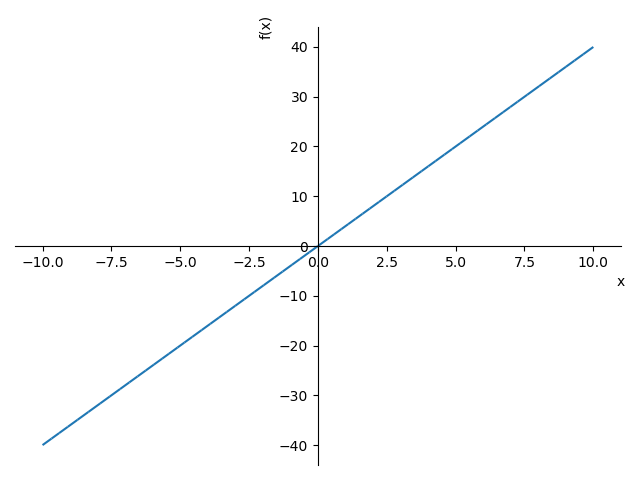


Integral: 
   3
2⋅x 
────
 3  


<IPython.core.display.Javascript object>


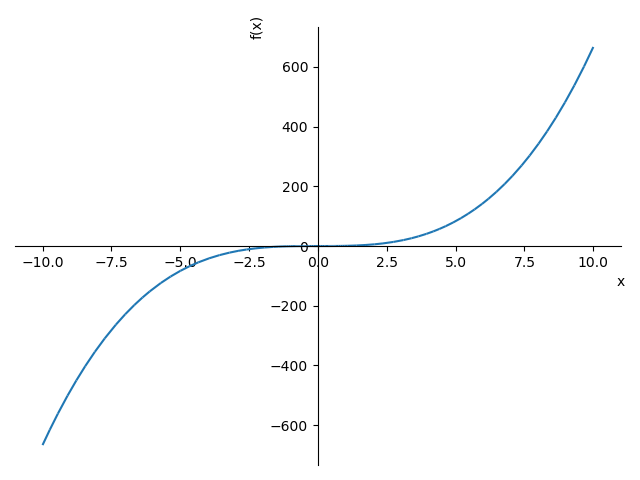

Equations system:

⎡⎛                      ____________                    ⎞  ⎛                  
⎢⎜   ⎛  31   √1241⎞    ╱ √1241   45                     ⎟  ⎜  ⎛  31   √1241⎞  
⎢⎜-2⋅⎜- ── + ─────⎟⋅  ╱  ───── + ──         ____________⎟  ⎜2⋅⎜- ── + ─────⎟⋅ 
⎢⎜   ⎝  4      4  ⎠ ╲╱     8     8         ╱ √1241   45 ⎟  ⎜  ⎝  4      4  ⎠ ╲
⎢⎜───────────────────────────────────, -  ╱  ───── + ── ⎟, ⎜──────────────────
⎣⎝                 7                    ╲╱     8     8  ⎠  ⎝                7 

   ____________                  ⎞  ⎛       ____________                      
  ╱ √1241   45                   ⎟  ⎜      ╱ 45   √1241  ⎛  √1241   31⎞       
 ╱  ───── + ──       ____________⎟  ⎜-2⋅  ╱  ── - ───── ⋅⎜- ───── - ──⎟       
╱     8     8       ╱ √1241   45 ⎟  ⎜   ╲╱   8      8    ⎝    4     4 ⎠       
───────────────,   ╱  ───── + ── ⎟, ⎜───────────────────────────────────, -  ╱
                 ╲╱     8     8  ⎠  ⎝                 7                    ╲╱ 

             ⎞  ⎛      ________

In [6]:
%matplotlib notebook
import matplotlib
from sympy import *


class NumPyStuff:
    @staticmethod
    def diff_int():
        x = Symbol('x')
        func = 2 * x ** 2
        print('Функция: ', str(func))
        print('Derivative: ')
        differencial = diff(func)
        pprint(differencial)
        plot(differencial)
        print('\nIntegral: ')
        integral = integrate(func)
        pprint(integral)
        plot(integral)


    @staticmethod
    def solving_equalities(*equalities):
        if len(equalities) == 1:
            return solve(equalities[0])
        return solve_poly_system(equalities)


    @staticmethod
    def solve_eq():
        x, y = symbols('x y')
        eq1 = Equality(10, x ** 2 + 3 * x * y)
        eq2 = Equality(7, y ** 2 - x * y)
        eq3 = Equality(x ** 2, 4)
        print('Equations system:\n')
        pprint(NumPyStuff.solving_equalities(eq1, eq2))
        print('Single equation:\n')
        pprint(NumPyStuff.solving_equalities(eq3))


if __name__ == '__main__':
    NumPyStuff.diff_int()
    init_printing()
    NumPyStuff.solve_eq()

8. Скачайте файл с информацией о всех государствах мира по [адресу](https://github.com/mledoze/countries/blob/master/dist/countries.csv). С помощью модуля pandas отобразите:
    1. 10 самых маленьких и самых больших стран мира по территории; 
    2. 10 самых маленьких и самых больших стран мира по населению; 
    3. все франкоязычные страны мира; 
    4. только островные государства; 
    5. все страны, находящиеся в южном полушарии. 

Сгруппируйте страны:
    - по первой букве; 
    - по населению; 
    - по территории. 

Программно сохраните в таблицу Excel все страны с выборочной информацией: название, столица, население, территория, валюта, широта, долгота.

In [5]:
import csv
import pandas as pd
from pandas import read_csv

countries_file = 'countries.csv'

class CSVStuff:
    @staticmethod
    def save_xls(table):
        names = pd.Series([d.split(',')[0] for d in table.name])
        names.name = 'name'
        lat, lng = zip(*[d.split(',')
                         if isinstance(d, str)
                         else ['nan', 'nan']
                         for d in table.latlng])
        lat, lng = map(pd.Series, (lat, lng))
        lat.name = 'latitude'
        lng.name = 'longitude'
        for_export = pd.concat([names, table[['capital', 'ccn3', 'area', 'currencies']], lat, lng], axis=1)
        with pd.ExcelWriter('exported.xls') as excel_writer:
            for_export.to_excel(excel_writer)

            
    @staticmethod
    def show_data():
        table = read_csv(countries_file, ',')
        print('\nСтраны с наибольшей площадью:\n')
        print(table.nlargest(n=10, columns='area')[['area', 'name']])
        print('\nСтраны с наименьшей площадью:\n')
        print(table.nsmallest(10, ['area'])[['area', 'name']])
        print('\nСтраны с наибольшим населением:\n')
        print(table.nlargest(10, ['ccn3'])[['ccn3', 'name']])
        print('\nСтраны с наименьшим населением:\n')
        print(table.nsmallest(10, ['ccn3'])[['ccn3', 'name']])
        print('\nФранкоязычные страны:\n')
        print(table[table.languages == 'French'][['languages', 'area', 'name']])
        print('\nОстровные страны:\n')
        print(table[table.borders.isnull()][['name']])
        CSVStuff.save_xls(table=table)
        print('\nСтраны из южного полушария:\n')
        print(table.where(pd.Series([float(str(d).split(',')[0]) < 0 for d in table.latlng])).name.dropna())
        #группировка стран по территории:
        for i, group in table.groupby(table.area):
            print(str(i) + ': ')
            for j, name in enumerate(group.name, 1):
                print(str(j) + '.', name.split(',')[0])


if __name__ == '__main__':
    CSVStuff.show_data()


Страны с наибольшей площадью:

           area                                               name
191  17098242.0  Russia,Russian Federation,Российская Федерация...
11   14000000.0                             Antarctica,Antarctica,
40    9984670.0          Canada,Canada,Canada,Canada,Canada,Canada
44    9706961.0        China,People's Republic of China,中华人民共和国,中国
235   9372610.0  United States,United States of America,United ...
33    8515767.0  Brazil,Federative Republic of Brazil,República...
14    7692024.0  Australia,Commonwealth of Australia,Commonweal...
105   3287590.0  India,Republic of India,Republic of India,Indi...
8     2780400.0  Argentina,Argentine Republic,Argentine Republi...
117   2724900.0  Kazakhstan,Republic of Kazakhstan,Қазақстан Ре...

Страны с наименьшей площадью:

      area                                               name
198  -1.00  Svalbard and Jan Mayen,Svalbard og Jan Mayen,S...
237   0.44  Vatican City,Vatican City State,Stato della Ci...
140   2.02  M


Страны из южного полушария:

2      Angola,Republic of Angola,República de Angola,...
8      Argentina,Argentine Republic,Argentine Republi...
10     American Samoa,American Samoa,American Samoa,A...
11                                Antarctica,Antarctica,
12     French Southern and Antarctic Lands,Territory ...
14     Australia,Commonwealth of Australia,Commonweal...
17     Burundi,Republic of Burundi,République du Buru...
27     Saint Helena, Ascension and Tristan da Cunha,S...
31     Bolivia,Plurinational State of Bolivia,Wuliwya...
33     Brazil,Federative Republic of Brazil,República...
37       Bouvet Island,Bouvet Island,Bouvetøya,Bouvetøya
38     Botswana,Republic of Botswana,Republic of Bots...
41     Cocos (Keeling) Islands,Territory of the Cocos...
43      Chile,Republic of Chile,República de Chile,Chile
48     Republic of the Congo,Republic of the Congo,Ré...
49     Cook Islands,Cook Islands,Cook Islands,Cook Is...
51     Comoros,Union of the Comoros,الاتحاد القمري,ال...
5

1. Nigeria
945087.0: 
1. Tanzania
1002450.0: 
1. Egypt
1030700.0: 
1. Mauritania
1098581.0: 
1. Bolivia
1104300.0: 
1. Ethiopia
1141748.0: 
1. Colombia
1221037.0: 
1. South Africa
1240192.0: 
1. Mali
1246700.0: 
1. Angola
1267000.0: 
1. Niger
1284000.0: 
1. Chad
1285216.0: 
1. Peru
1564110.0: 
1. Mongolia
1648195.0: 
1. Iran
1759540.0: 
1. Libya
1886068.0: 
1. Sudan
1904569.0: 
1. Indonesia
1964375.0: 
1. Mexico
2149690.0: 
1. Saudi Arabia
2166086.0: 
1. Greenland
2344858.0: 
1. DR Congo
2381741.0: 
1. Algeria
2724900.0: 
1. Kazakhstan
2780400.0: 
1. Argentina
3287590.0: 
1. India
7692024.0: 
1. Australia
8515767.0: 
1. Brazil
9372610.0: 
1. United States
9706961.0: 
1. China
9984670.0: 
1. Canada
14000000.0: 
1. Antarctica
17098242.0: 
1. Russia
